# 3 Seminar

Hi! Today we are going to learn about image segmentation and object detection. We'll write and train some simple neural models for image segmentation, and look how object detection models work.


In [ ]:
from catalyst.utils import set_global_seed, get_device
from datetime import datetime


import tkinter
import matplotlib
matplotlib.use('TkAgg')

set_global_seed(42)
device = get_device()

## Segmentation

### Dataset

Look at the today task: cell segmentation! It's the dataset [ADDI](https://www.fc.up.pt/addi/ph2%20database.html). The dataset contained medical photo of skin with a mole or a melonoma. We'll just segment them on photo, without classification.

<table><tr><td>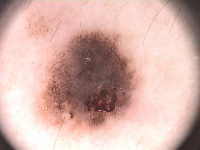</td><td>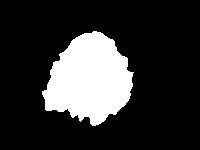</td></tr></table>

Download the archive and uncompess it.



In [ ]:
# for local notebook on win

# import urllib.request

# url = 'https://www.dropbox.com/s/k88qukc20ljnbuo'
# filename = 'PH2Dataset.rar'
# urllib.request.urlretrieve(url, filename)

In [ ]:
# for colab or os

# !wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

# get_ipython().system_raw("unrar x PH2Dataset.rar")

Let's show the images

In [ ]:
import os
from pathlib import Path

from cv2 import erode
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate, rescale, resize

import catalyst
from catalyst import dl

from skimage.io import imread

In [ ]:
root = 'PH2Dataset'

# collect all data paths
path = Path(root) / Path('PH2 Dataset images')
image_list_name = list(path.rglob('*Dermoscopic_Image/*'))
lesion_list_name = list(path.rglob('*lesion/*'))
    
image_list_name = np.array(image_list_name)
lesion_list_name = np.array(lesion_list_name)

print('Amount of images is:', len(image_list_name))

Let's explore a sample image and mask from dataset

In [ ]:
sample_image_name = np.random.choice(image_list_name, 1)[0]
sample_image = imread(sample_image_name)

sample_lesion_name = np.random.choice(lesion_list_name, 1)[0]
sample_lesion = imread(sample_lesion_name)

s = f'Image shae: {sample_image.shape}, \nLesion shape: {sample_lesion.shape}'
print(s) 

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(6.4, 4.8))

ax[0].imshow(sample_image)
ax[1].imshow(sample_lesion)
plt.show()

In [ ]:
thr = 0.5

example_lesion = sample_lesion / 255  # norm it 
transformed_lesion = (rotate(example_lesion, 40) > thr) * 1.0  # to float

_, ax = plt.subplots(1, 2, figsize=(6.8, 4.8))

ax[0].imshow(example_lesion, cmap="gray")
ax[1].imshow(transformed_lesion, cmap="gray")
plt.show()

### IoU

Let's explore the most similar segmentation's metric - Intersetion over Union (IoU). The visual interpretation is shown on image below:

![iou](https://pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

In [ ]:
# pass code
intersection = (example_lesion == 1) & (transformed_lesion == 1)  # Calculate intersection


# visual interpretion
## ground true mask
red_true = np.concatenate(
    [example_lesion[:, :, np.newaxis], np.zeros(example_lesion.shape + (2,))],
    axis=2,
)

## our predict mask
blue_fake = np.concatenate(
    [
        np.zeros(example_lesion.shape + (2,)),
        transformed_lesion[:, :, np.newaxis],
    ],
    axis=2,
)

_, ax = plt.subplots(1, 3, figsize=(6.4 * 1.5, 4.8 * 1.))

ax[0].imshow(red_true)
ax[1].imshow((intersection[:,:,np.newaxis] * 0.5 + red_true + blue_fake))
ax[2].imshow(blue_fake)
plt.show()

In [ ]:
# pass code 
union = (example_lesion == 1) | (transformed_lesion == 1)  # Calculate union

# visual interpretion
## ground true mask
red_true = np.concatenate(
    [example_lesion[:, :, np.newaxis], np.zeros(example_lesion.shape + (2,))],
    axis=2,
)

## our predict mask
blue_fake = np.concatenate(
    [
        np.zeros(example_lesion.shape + (2,)),
        transformed_lesion[:, :, np.newaxis],
    ],
    axis=2,
)

_, ax = plt.subplots(1, 3, figsize=(6.4 * 1.5, 4.8 * 1.5))

ax[0].imshow(red_true)
ax[1].imshow(union, cmap="gray")
ax[2].imshow(blue_fake)
plt.show()

In [ ]:
# naive calculation of iou
iou = np.sum(intersection) / np.sum(union)
print(f"Current IoU: {iou}")

Is it loss? We need recalcylate with "smooth" realisation.

In [ ]:
intersection_l = example_lesion * transformed_lesion  # Calculate "smooth" intersection
union_l = example_lesion + transformed_lesion - intersection_l  # Calculate "smooth" union
iou_l = np.sum(intersection_l) / np.sum(union_l)

print(f"IoU: {iou_l}, Current IoU Loss: {1 - iou_l}")

See that metric on ```catalyst```

In [ ]:
import torch
from catalyst import metrics

metric = metrics.IOUMetric()
metric.reset()

gt = torch.from_numpy(transformed_lesion)
predict = torch.from_numpy(example_lesion)

metric.update_key_value(gt, predict)
metric.compute_key_value()['iou/_micro']

### Dice

The another segmentation metric is Dice, that very simialr on IoU and is shown on the image below:

![](https://miro.medium.com/max/858/1*yUd5ckecHjWZf6hGrdlwzA.png)

Let's try to realise naive calculation of Dice

In [ ]:
intersection = example_lesion * transformed_lesion # Calculate intersection

recall = np.sum(intersection) / np.sum(example_lesion) # Calculate recall
precision = np.sum(intersection) / np.sum(transformed_lesion) # Calculate precision
print(f"Recall: {recall}. Precision: {precision}")

Remind that $F_1$ score is:

$$ F_1 = \frac{Precision * Recall}{Precision + Recall} $$

In [ ]:
f1 = 2 / (1 / recall + 1 / precision) # Calculate f1
print(f"F1: {f1}")

In [ ]:
# Rewrite formula with intersection, predictions and ground truth
f1 = (
    2 * np.sum(intersection) / (np.sum(example_lesion) + np.sum(transformed_lesion))
)
print(f"Another F1: {f1}. It's DICE!")

In [ ]:
gt = torch.from_numpy(transformed_lesion)
predict = torch.from_numpy(example_lesion)

metric = metrics.dice(gt, predict, mode="micro")
print('Dice from catalyst:', metric)

### Morphological Transformations


Morphological transformation is a useful toolkit to enhance maskes or semantic maps. If a mask is noisy, we can remove error points by erosion.

In [ ]:
thr =  0.5  # threshold value

transformed_lesion = rotate(example_lesion, 40) * 1.0

# create noise
noise = np.random.randn(*(s // 20 for s in example_lesion.shape))
noise = rescale(noise, 30)[:example_lesion.shape[0], :example_lesion.shape[1]]
noised_mask = 0.7 * transformed_lesion + 0.3 * noise

# min-max normalization
noised_mask = (noised_mask - noised_mask.min()) / (noised_mask.max() - noised_mask.min())

# plot results
_, ax = plt.subplots(1, 3, figsize=(6.4 * 1.5, 4.8 * 1.5))

ax[0].imshow(example_lesion, cmap="gray")
ax[1].imshow(transformed_lesion > thr, cmap="gray")
ax[2].imshow(noised_mask > thr, cmap="gray")
plt.show()

How erosion works?

In [ ]:
kernel = np.ones((3, 3)).astype(np.uint8)
print(f"Kernel:\n{kernel}")

example = np.ones((10, 10))
example[3, 4] = 0
print(f"Example:\n{example}")

padded_example = np.zeros((12, 12))
padded_example[1:11, 1:11] = example
result = np.zeros((10, 10)) 
for i in range(10):
    for j in range(10):
        result[i, j] = np.min(padded_example[i:i + 3, j:j + 3] * kernel)

print(f"Result:\n{result}")

Let's use it.


In [ ]:
kernel = np.ones((5, 5)).astype(np.uint8)
eroded = erode((noised_mask * 255).astype(np.uint8), kernel, iterations=5) / 255

_, ax = plt.subplots(1, 3, figsize=(6.4 * 1.5, 4.8 * 1.5))

ax[0].imshow(example_lesion, cmap="gray")
ax[1].imshow(noised_mask > thr, cmap="gray")
ax[2].imshow(eroded > thr, cmap="gray")
plt.show()

## Data Augmentation


In [ ]:
import typing as tp
from torch.utils.data import Dataset
import albumentations as A


class SegmentationDataset(Dataset):
    def __init__(
            self,
            images: np.array,
            masks: tp.Optional[np.array] = None,
            transforms: tp.Optional[A.BasicTransform] = None
    ) -> None:
        self.image_fname_list = images
        self.mask_fname_list = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.image_fname_list)

    def __getitem__(self, idx: int) -> dict:
        image = imread(self.image_fname_list[idx])
        mask = imread(self.mask_fname_list[idx])
        
        # check for dimensions
        if mask.ndim == 2:
            mask = mask[..., np.newaxis]
            
        if image.ndim == 2:
            mask = mask[..., np.newaxis]

        result = {"image": image, "mask": mask}

        if self.transforms is not None:
            result = self.transforms(**result)
            
        result['mask'] = result['mask'].permute(2, 0, 1).float()

        return result

In [ ]:
from albumentations.pytorch import ToTensorV2 as ToTensor


def pre_transform(image_size: int = 256) -> A.BasicTransform:
    return A.Resize(image_size, image_size, always_apply=True)


def augmentations() -> A.BasicTransform:
    channel_augs = [
        A.HueSaturationValue(hue_shift_limit=10, 
                             sat_shift_limit=10,
                             val_shift_limit=10, 
                             p=0.5),
        A.ChannelShuffle(p=0.5),
    ]

    result = [
        A.OneOf([
            A.IAAAdditiveGaussianNoise(), 
            A.GaussNoise()
        ], p=0.5),
        A.OneOf([
            A.MotionBlur(blur_limit=3, p=0.7),
            A.MedianBlur(blur_limit=3, p=1.0),
            A.Blur(blur_limit=3, p=0.7),
        ], p=0.5),
        A.OneOf(channel_augs, p=0.5),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(), 
            A.IAAEmboss()
        ], p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.5,
                                      contrast_limit=0.5,
                                      p=0.5),
        A.RandomGamma(p=0.5),
        A.OneOf([
            A.MedianBlur(p=0.5),
            A.MotionBlur(p=0.5)
        ], p=0.6),
        A.RandomGamma(gamma_limit=(85, 115), p=0.5),
    ]
    return A.Compose(result)


def post_transform():
    return A.Compose([
        A.Normalize(mean=0, 
                    std=1,
                    max_pixel_value=255),
        ToTensor()
    ])

In [ ]:
# Create train pipeline
image_size = 256
train_transformation = A.Compose([
    pre_transform(image_size), augmentations(), post_transform()
])


# Create valid pipeline
valid_transformation = A.Compose([
    pre_transform(image_size), post_transform()
])  

Before train - plot some resuls of augmentation. Always check it!

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(6.4 * 1.5, 4.8 * 1.5))

for i in range(4):
    aug_image = train_transformation(image=sample_image)["image"].permute(1, 2, 0).numpy()
    ax[i % 2][i // 2].imshow(aug_image)
    
plt.show()

The other important point - check mask augmentation

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(6.4 * 1.5, 4.8 * 1.5))

for i in range(4):
    aug_mask = train_transformation(image=sample_image, 
                                     mask=sample_lesion)["mask"].numpy()
    ax[i % 2][i // 2].imshow(aug_mask)
    
plt.show()

In [ ]:
from torch.utils.data import DataLoader, random_split

batch_size = 8
num_workers = 0  # num_workers = 0 for local notebook on win 

indexes = np.arange(len(image_list_name))
np.random.shuffle(indexes)
train_indexes = indexes[:int(0.8 * len(image_list_name))]
valid_indexes = indexes[int(0.8 * len(lesion_list_name)):]

train_dataset = SegmentationDataset(
    image_list_name[train_indexes],
    lesion_list_name[train_indexes],
    train_transformation
)
train_loader = DataLoader(
    train_dataset, 
    shuffle=True,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
    # Create train loader
)

valid_dataset = SegmentationDataset(
    image_list_name[valid_indexes],
    lesion_list_name[valid_indexes],
    valid_transformation
) 
valid_loader = DataLoader(
    valid_dataset, 
    shuffle=True,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
    # Create valid loader
)

loaders = {"train": train_loader, "valid": valid_loader}

Check data loaders!

In [ ]:
batch = next(iter(train_loader))
image, mask = batch['image'], batch['mask']

print('Image batch shape:', image.shape)
print('Mask batch shape:', mask.shape)

### U-Net

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, in_channels=3, n_classes=10):
        super().__init__()
        self.d_block_1 = self.down_block(in_channels, 112)
        self.d_block_2 = self.down_block(112, 224)
        self.d_block_3 = self.down_block(224, 448)
        
        self.b_neck = self.bottleneck(448, 448)
        
        self.up_block_1 = self.up_block(448, 224)
        self.up_block_2 = self.up_block(224, 112)
        self.up_block_3 = self.up_block(112, 16)
        
        self.logit = nn.Conv2d(16, n_classes, kernel_size=1)
    
    def down_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        return block
    
    
    def bottleneck(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        return block
    
    
    def up_block(self, in_channels, out_channels):
        block = nn.ModuleList([
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(2 * in_channels),
            nn.ReLU(),
            nn.Conv2d(2 * in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ])
        return block

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.d_block_1(x)
        x2 = self.d_block_2(F.max_pool2d(x1, kernel_size=2, stride=2))
        x3 = self.d_block_3(F.max_pool2d(x2, kernel_size=2, stride=2))
        
        b_neck = self.b_neck(F.max_pool2d(x3, kernel_size=2, stride=2))
        
        y3 = self.up_block_1[0](b_neck)
        y3 = torch.cat([y3, x3], dim=1)
        for m in self.up_block_1[1:]:
            y3 = m(y3)
        
        y2 = self.up_block_2[0](y3)        
        y2 = torch.cat([y2, x2], dim=1)
        for m in self.up_block_2[1:]:
            y2 = m(y2)
            
        y1 = self.up_block_3[0](y2)        
        y1 = torch.cat([y1, x1], dim=1)
        for m in self.up_block_3[1:]:
            y1 = m(y1)
        
        output = self.logit(y1)
        
        return output

Check model

In [ ]:
model = UNet(in_channels=3, n_classes=10)

x = torch.ones((8, 3, 256, 256))  # dummy input
out = model(x)
print(out.shape)

out = out.detach()
out = torch.sigmoid(out)

In [ ]:
batch = next(iter(train_loader))
image, mask = batch['image'], batch['mask']

print('Image batch shape:', image.shape)
print('Mask batch shape:', mask.shape)

out = model(image)

Check results

In [ ]:
image = out[0, ...]
print(image.shape)
image = image.permute(1, 2, 0).numpy()

plt.imshow(image[..., 2])
plt.show()

In [ ]:
from catalyst.contrib.nn.optimizers.radam import RAdam
from catalyst.contrib.nn.criterion import DiceLoss, IoULoss


model = UNet(in_channels=3, n_classes=1)
optimizer = RAdam(model.parameters(), lr=1e-3)

criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}

callbacks = [
    dl.CriterionCallback(
        target_key="mask", input_key="logits",  criterion_key="dice", metric_key ='loss_dice'
    ),
    dl.CriterionCallback(
        target_key="mask", input_key="logits", criterion_key="iou", metric_key ='loss_iou'
    ),
    dl.CriterionCallback(
        target_key="mask", input_key="logits",  criterion_key="bce", metric_key ='loss_bce'
    ),
    dl.MetricAggregationCallback(
        metric_key="loss",
        mode="weighted_sum",
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),
    dl.DiceCallback(target_key="mask", input_key="logits", prefix='seg_dice'),
    dl.IOUCallback(target_key='mask', input_key='logits', prefix='seg_iou'),
    dl.CheckpointCallback(logdir=Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
                          loader_key="valid", metric_key="loss", minimize=True),
]

In [ ]:
runner = dl.SupervisedRunner(input_key="image", target_key="mask")

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    callbacks=callbacks,
    minimize_valid_metric=False,
    valid_metric='seg_iou',
    logdir=Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
    num_epochs=1,
    load_best_on_end=True,
    verbose=True,
)

Let's look at the mask!

In [ ]:
from torch.nn.functional import interpolate


pt_image = valid_transformation(image=sample_image)["image"].unsqueeze(0)
model.eval()

pt_mask = torch.sigmoid(model(pt_image).detach().cpu())
pt_mask = interpolate(pt_mask, sample_image.shape[:-1]).squeeze()
example_mask = pt_mask.squeeze().numpy()


_, ax = plt.subplots(1, 3, figsize=(6.4 * 1.5, 4.8 * 1.5))

ax[0].imshow(sample_image)
ax[1].imshow(sample_lesion)
ax[2].imshow(example_mask, cmap='gray')
plt.show()

### Catalyst.Contrib

Catalyst already has a segmentation models generator.
There is a huge variety of model architectures, let's try one of them!

In [ ]:
from catalyst.contrib.models.cv.segmentation.unet import Unet

model = Unet()
optimizer = RAdam(model.parameters(), lr=1e-3)

runner = dl.SupervisedRunner(input_key="image", target_key="mask")

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    callbacks=callbacks,
    minimize_valid_metric=False,
    valid_metric='seg_iou',
    logdir=Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S"),
    num_epochs=1,
    load_best_on_end=True,
    verbose=True,
)

In [ ]:
pt_image = valid_transformation(image=sample_image)["image"].unsqueeze(0)
model.eval()

pt_mask = torch.sigmoid(model(pt_image).detach().cpu())
pt_mask = interpolate(pt_mask, sample_image.shape[:-1]).squeeze()
example_mask = pt_mask.squeeze().numpy()


_, ax = plt.subplots(1, 3, figsize=(6.4 * 1.5, 4.8 * 1.5))

ax[0].imshow(sample_image)
ax[1].imshow(sample_lesion)
ax[2].imshow(example_mask, cmap='gray')
plt.show()

## Object Detection

This part based on tutorial from [github](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection).

 Firstly download all necessary files. They contain a codebase, finetuned model's state dict and fonts for showing bounding boxes.




In [ ]:
# for colab on os

# !git clone https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection
# !mv a-PyTorch-Tutorial-to-Object-Detection/* .
# !gdown https://drive.google.com/uc?id=1zmx5FXcnE9WC_rIZhh0qsy8Zom32YwNz&export=download
# !unzip Calibri_Font_Family.zip
# !gdown https://drive.google.com/uc?id=1bvJfF6r_zYl2xZEpYXxgb7jLQHFZ01Qe&export=download

Choose the victim. Object detection usualy is used for self-driving cars, so try to detect pedectrians on a  photo.

In [ ]:
# for local notebook on win

# url = 'https://www1.nyc.gov/html/dot/images/pedestrians/'
# filename = 'ped-ramps-bay-ridge-ave.jpg'
# urllib.request.urlretrieve(url, filename)

In [3]:
# !wget https://www1.nyc.gov/html/dot/images/pedestrians/ped-ramps-bay-ridge-ave.jpg

import os
os.chdir('a-PyTorch-Tutorial-to-Object-Detection-master/')

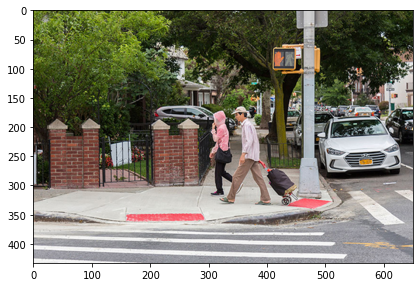

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
from copy import deepcopy

original_image = Image.open('ped-ramps-bay-ridge-ave.jpg')

plt.figure(figsize=(6.8, 4.8))
plt.imshow(original_image)
plt.show()

Prepare the image and the model.

In [5]:
from torchvision import transforms
from utils import *
from PIL import Image, ImageDraw, ImageFont

from model import SSD300

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model checkpoint
checkpoint = 'checkpoint_ssd300.pth.tar'
checkpoint = torch.load(checkpoint, map_location=device)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = SSD300(checkpoint['model'].n_classes)
model.load_state_dict(checkpoint['model'].state_dict())
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300)) # Create resize transformer image to (300, 300)
to_tensor = transforms.ToTensor() # Create torch transformer
normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),) # Create normalizer

c:\users\keleas\anaconda3\envs\catalyst\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
c:\users\keleas\anaconda3\envs\catalyst\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)



Loaded checkpoint from epoch 232.


Loaded base model.



Get model predictions. Object detection models usually returns class probabilities and bounding boxes predictions.

In [6]:
image = normalize(to_tensor(resize(original_image)))

# Move to default device
image = image.to(device)

# Forward prop.
predicted_locs, predicted_scores = model(image.unsqueeze(0))

Let's look into predicted locs and labels.

Locs shape: torch.Size([8732, 4]), scores shape: torch.Size([8732, 21])


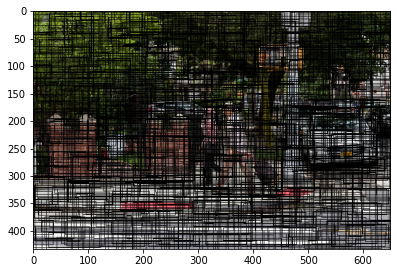

In [7]:
print(f"Locs shape: {predicted_locs.size()[1:]}, scores shape: {predicted_scores.size()[1:]}")

annotated_image = deepcopy(original_image)
draw = ImageDraw.Draw(annotated_image)

decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[0], model.priors_cxcy)).cpu().detach()

original_dims = torch.FloatTensor(
    [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
decoded_locs = decoded_locs * original_dims # Map locations to original image

for box_loc in decoded_locs[::10]:
    box_loc = box_loc.numpy()
    draw.rectangle(xy=[l + 1. for l in box_loc], outline="black") 

plt.figure(figsize=(6.4, 4.8))
plt.imshow(annotated_image)
plt.show()

Filter boxes by on model confidence.

Filtered locations: 52


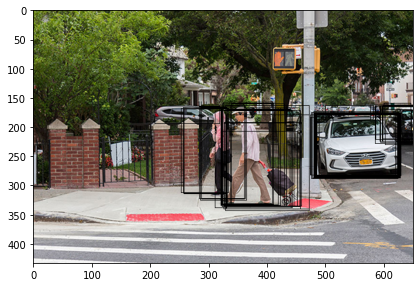

In [8]:
import torch.nn.functional as F

probs = F.softmax(predicted_scores[0], dim=1)
# First class – background
best_scores, best_cls = torch.max(probs[:, 1:], 1)  # Find the best class for each box

filtered = decoded_locs[best_scores >= 0.2]
print(f"Filtered locations: {len(filtered)}")

annotated_image = deepcopy(original_image)
draw = ImageDraw.Draw(annotated_image)

for box_loc in filtered:
    box_loc = box_loc.numpy()
    draw.rectangle(xy=[l for l in box_loc], outline="black")


plt.figure(figsize=(6.8, 4.8))
plt.imshow(annotated_image)
plt.show()

Calculate IoU(or Jaccard index, same things) to find overlapping boxes.
This is the Non-Maximum Suppression algorithm.

After another filter: 7 boxes


c:\users\keleas\anaconda3\envs\catalyst\lib\site-packages\ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


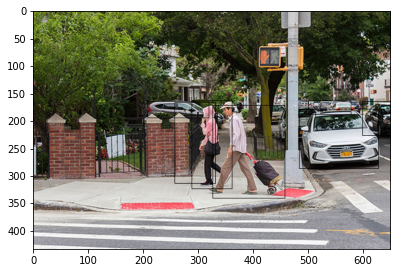

In [9]:
annotated_image = deepcopy(original_image)
draw = ImageDraw.Draw(annotated_image)

filtered_scores = best_scores[best_scores > 0.2]
filtered_cls = best_cls[best_scores > 0.2]

result_box = []
result_cls = []

for c in range(0, model.n_classes):
    _, indeces = torch.sort(filtered_scores[filtered_cls == c], descending=True)# Filter scores and sort them from bigger to smaller
    cls_boxes = filtered[filtered_cls == c]
    cls_boxes = cls_boxes[indeces]
    overlap = find_jaccard_overlap(cls_boxes, cls_boxes)

    suppress = torch.zeros(cls_boxes.size(0), dtype=torch.uint8)
    for i in range(cls_boxes.size(0)):
        if suppress[i] == 1:
            continue

        condition = overlap[i] > 0.5
        condition = torch.tensor(condition, dtype=torch.uint8)
        suppress = torch.max(suppress, condition) 

        suppress[i] = 0

    for s, box in zip(suppress, cls_boxes):
        if s < 1:
            result_box.append(box)
            result_cls.append(c)

print(f"After another filter: {len(result_box)} boxes")
for box_loc in result_box:
    box_loc = box_loc.numpy()
    draw.rectangle(xy=[l for l in box_loc], outline="black") 

plt.figure(figsize=(6.4, 4.8))
plt.imshow(annotated_image)
plt.show()

And the last task is creating annotations!

In [ ]:
annotated_image = deepcopy(original_image)
draw = ImageDraw.Draw(annotated_image)
font = ImageFont.truetype("./Calibri 400.ttf", 15)

for i in range(len(result_box)):
    box_location = result_box[i].numpy()
    label = rev_label_map[result_cls[i] + 1]
    draw.rectangle(xy=box_location, outline=label_color_map[label])
    draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[label]) 

    text_size = font.getsize(label.upper())
    text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
    textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                        box_location[1]]
    draw.rectangle(xy=textbox_location, fill=label_color_map[label])
    draw.text(xy=text_location, text=label.upper(), fill='white',
                font=font)
    
plt.figure(figsize=(6.4, 4.8))
plt.imshow(annotated_image)
plt.show()

### Extras
Change model from the old SSD300 to the modern EfficientDet.
Implementation and pretrained model's weights you can find in [@toandaominh1997/EfficientDet.Pytorch](https://github.com/toandaominh1997/EfficientDet.Pytorch).